In [1]:
#The use_safetensors=True argument is set to enable safe tensor operations, 
#which is important for training and inference on GPUs.
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", 
                                    use_safetensors=True).to("cuda")

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler


In [3]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", 
                                    subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", 
                                          subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", 
    use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [4]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features

In [5]:
#define the text prompt, height, width, number of denoising steps, 
#guidance scale, generator seed, and batch size
prompt = ["A unicorn sitting on a rainbow"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 3.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

In [6]:
#tokenizes the text prompt and converts it to a PyTorch tensor.
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, 
    truncation=True, return_tensors="pt"
)


These lines encode the text prompt and the empty prompt to obtain text 
embeddings. The empty prompt embeddings are used to guide the diffusion process
towards generating images that are consistent with the text prompt. The text 
embeddings are then concatenated together.

In [7]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [8]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [9]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [10]:
#generate a random latent noise image and normalize it.
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

C:\Users\Rhea Pandita\AppData\Local\Temp\ipykernel_18636\4202316515.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [11]:
latents = latents * scheduler.init_noise_sigma

In [12]:
#sets the number of denoising steps for the diffusion process.
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)


In [13]:
'''
This loop iterates over the timesteps and performs the following steps:

1. The latent_model_input variable is expanded if classifier-free guidance is 
enabled. This avoids doing two forward passes.
2. The latent_model_input variable is scaled using the scheduler's 
scale_model_input() function.
3. The noise residual is predicted using the U-Net model.
4. Classifier-free guidance is performed by combining the predicted noise 
residual for the unconditional prompt and the predicted noise residual for 
the text prompt.
5. The previous noisy sample is computed using the scheduler's step() function
'''
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, 
                                                     timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, 
                          encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
# scale and decode the image latents with vae
#scale the latent noise image and decode it to obtain the final image
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

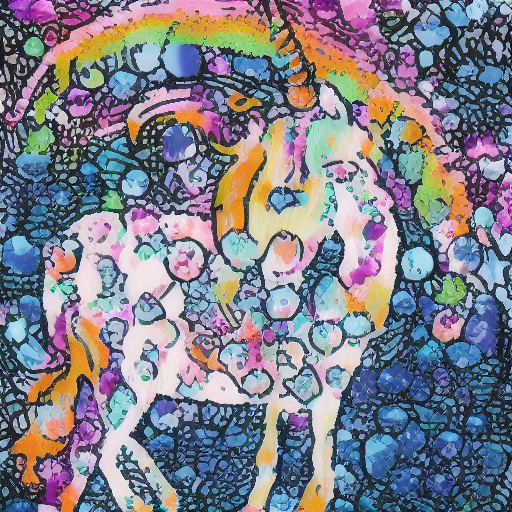

In [15]:
#convert the denoised image to a PIL Image object and display it.
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image